In [22]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy
import networkx as nx
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from shapely import wkt
from scipy.spatial import distance

In [23]:
flows = pd.read_csv('data.csv')
flows['jobs'] = flows['jobs'] - 0.1

In [24]:
flows.head()

,station_origin,station_destination,flows,population,jobs,distance,unconstrainedEst1,log_population,log_jobs,log_distance,unconstrainedEst2,fitted
0,Abbey Road,Bank and Monument,0,599.1,78549.0,8131.625097,10,6.395429,11.271479,9.003516,50,49.622673
1,Abbey Road,Beckton,1,599.1,442.0,8510.221774,0,6.395429,6.091536,9.049023,1,0.937341
2,Abbey Road,Blackwall,3,599.1,665.0,3775.548872,0,6.395429,6.499937,8.236301,2,2.121621
3,Abbey Road,Canary Wharf,1,599.1,58772.0,5086.614220,18,6.395429,10.981423,8.534368,53,53.302060
4,Abbey Road,Canning Town,37,599.1,15428.0,2229.023167,25,6.395429,9.643946,7.709319,32,32.210949


In [25]:
flows['log_dest_jobs'] = np.log(flows['jobs'] + .001)
eq_form_1 = 'flows ~ station_origin + log_dest_jobs + log_distance-1'
sim = smf.glm(formula = eq_form_1, data = flows, family=sm.families.Poisson()).fit()
print(sim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Sat, 27 Apr 2024   Deviance:                   1.8615e+06
Time:                        13:21:17   Pearson chi2:                 2.78e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [87]:
constraints = {'log_distance': -1.7564}
sim_constrained = smf.glm(formula=eq_form_1, data=flows, family=sm.families.Poisson()).fit_constrained(constraints)
print(sim_constrained.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61014
Model Family:                 Poisson   Df Model:                          398
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3447e+06
Date:                Sat, 27 Apr 2024   Deviance:                   2.5173e+06
Time:                        18:03:58   Pearson chi2:                 5.83e+06
No. Iterations:                     1   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [127]:
constraints2 = {'log_distance': -2.6346}
sim_constrained2 = smf.glm(formula=eq_form_1, data=flows, family=sm.families.Poisson()).fit_constrained(constraints2)
print(sim_constrained2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61014
Model Family:                 Poisson   Df Model:                          398
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3338e+06
Date:                Sat, 27 Apr 2024   Deviance:                   4.4953e+06
Time:                        22:31:51   Pearson chi2:                 5.94e+07
No. Iterations:                     1   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [130]:
predicted_flows = sim_constrained.predict(flows)
predicted_flows2 = sim_constrained2.predict(flows)
flows['predicted_flows'] = predicted_flows.astype(int)
flows['predicted_flows2'] = predicted_flows2.astype(int)
print(flows[['station_origin','station_destination', 'flows','predicted_flows','predicted_flows2']].head(10))

  station_origin station_destination  flows  predicted_flows  predicted_flows2
0     Abbey Road   Bank and Monument      0               13                 3
1     Abbey Road             Beckton      1                0                 0
2     Abbey Road           Blackwall      3                0                 0
3     Abbey Road        Canary Wharf      1               24                 8
4     Abbey Road        Canning Town     37               32                14
5     Abbey Road        Crossharbour      1                0                 0
6     Abbey Road        Custom House      0                1                 0
7     Abbey Road          Cutty Sark      2                0                 0
8     Abbey Road              Cyprus      7                0                 0
9     Abbey Road         Devons Road      1                0                 0


In [131]:
grouped_flows = flows.groupby('station_destination').agg({'predicted_flows':'sum', 'predicted_flows2':'sum'})

grouped_flows_original = flows.groupby('station_destination')['flows'].sum()

result = pd.concat([grouped_flows_original, grouped_flows], axis=1)

print(result)

                     flows  predicted_flows  predicted_flows2
station_destination                                          
Abbey Road             345              921               894
Acton Central          750              264               153
Acton Town            2202             2082              2488
Aldgate               7782             7708              4485
Aldgate East          7932             8179              5331
...                    ...              ...               ...
Wood Street            404              617               783
Woodford               706              498               578
Woodgrange Park        242              195               196
Woodside Park          745              576              1082
Woolwich Arsenal      4428              557               301

[398 rows x 3 columns]


In [155]:
# calculate flows_change1
result['flows_change1'] = (result['predicted_flows'] - result['flows'])/result['flows']*100
result['flows_change2'] = (result['predicted_flows2'] - result['flows'])/result['flows']*100
print(result[['flows', 'predicted_flows','predicted_flows2', 'flows_change1','flows_change2']].head(10))

                     flows  predicted_flows  predicted_flows2  flows_change1  \
station_destination                                                            
Abbey Road             345              921               894     166.956522   
Acton Central          750              264               153     -64.800000   
Acton Town            2202             2082              2488      -5.449591   
Aldgate               7782             7708              4485      -0.950912   
Aldgate East          7932             8179              5331       3.113969   
All Saints             444              438               188      -1.351351   
Alperton               741              378               410     -48.987854   
Amersham               256               39                58     -84.765625   
Anerley                173              180               159       4.046243   
Angel                 8103             7387              4518      -8.836233   

                     flows_change2  
st

##### 2 Times

In [156]:
# Print the top 10 largest percentage differences
print("Print the top 10 largest percentage differences:")
print(result[['flows', 'predicted_flows', 'flows_change1']].nlargest(10, 'flows_change1'))

# Print the top 10 smallest percentage differences
print("\nPrint the top 10 smallest percentage differences:")
print(result[['flows', 'predicted_flows', 'flows_change1']].nsmallest(10, 'flows_change1'))


前10个最大的百分比差异：
                       flows  predicted_flows  flows_change1
station_destination                                         
Stratford High Street    788             5171     556.218274
Elverson Road            226             1144     406.194690
Gidea Park               299             1086     263.210702
Goodmayes                683             2415     253.587116
Rotherhithe              321             1103     243.613707
Seven Kings              559             1696     203.398927
Maryland                 350             1054     201.142857
Abbey Road               345              921     166.956522
Penge West               150              397     164.666667
West India Quay          400             1036     159.000000

前10个最小的百分比差异：
                     flows  predicted_flows  flows_change1
station_destination                                       
Chesham                243               14     -94.238683
Woolwich Arsenal      4428              557     -87.420958
Epp

##### 3 Times

In [157]:
# Print the top 10 largest percentage differences
print("Print the top 10 largest percentage differences:")
print(result[['flows', 'predicted_flows', 'flows_change2']].nlargest(10, 'flows_change2'))

# Print the top 10 smallest percentage differences
print("\nPrint the top 10 smallest percentage differences:")
print(result[['flows', 'predicted_flows', 'flows_change2']].nsmallest(10, 'flows_change2'))

前10个最大的百分比差异：
                       flows  predicted_flows  flows_change2
station_destination                                         
Stratford High Street    788             5171    1640.101523
Elverson Road            226             1144     761.061947
Gidea Park               299             1086     362.876254
Rotherhithe              321             1103     353.894081
Goodmayes                683             2415     351.244510
Fairlop                  182              322     321.428571
Ruislip Manor            408              649     276.715686
Penge West               150              397     254.666667
St James Street          184              419     225.000000
Seven Kings              559             1696     221.466905

前10个最小的百分比差异：
                     flows  predicted_flows  flows_change2
station_destination                                       
Chesham                243               14     -94.650206
Woolwich Arsenal      4428              557     -93.202349
New

#### plot of flows_change1

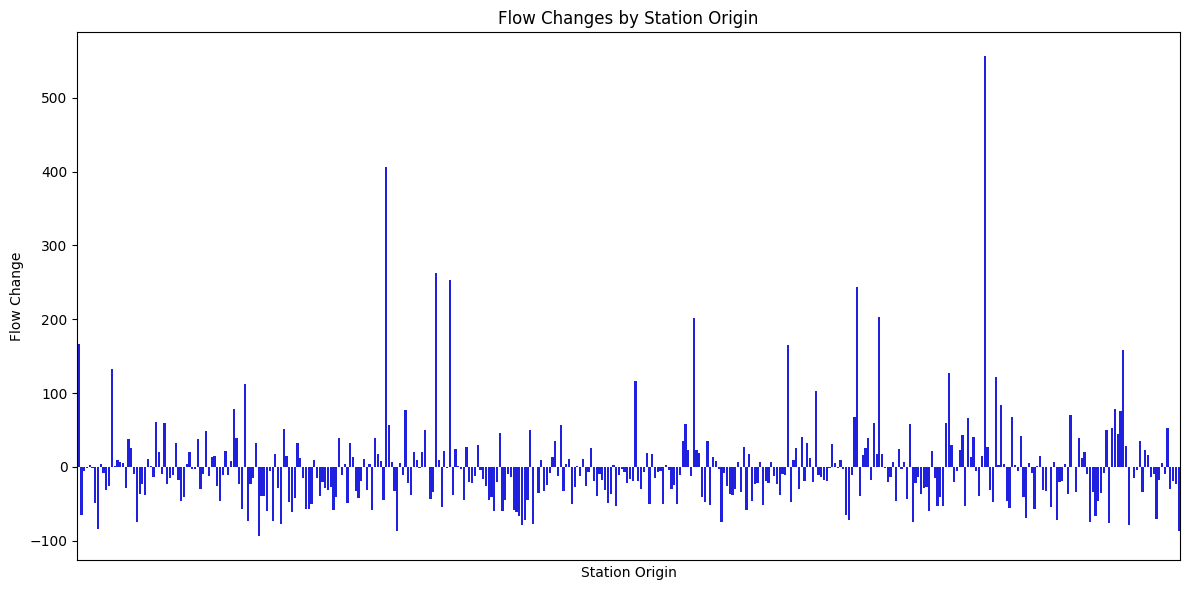

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

plt.figure(figsize=(12, 6))
sns.barplot(data=result, x='station_destination', y='flows_change1', color='b')
plt.xlabel('Station Origin')
plt.ylabel('Flow Change')
plt.title('Flow Changes by Station Origin')
plt.xticks([])
plt.tight_layout()
plt.show()


#### plot of flows_change2

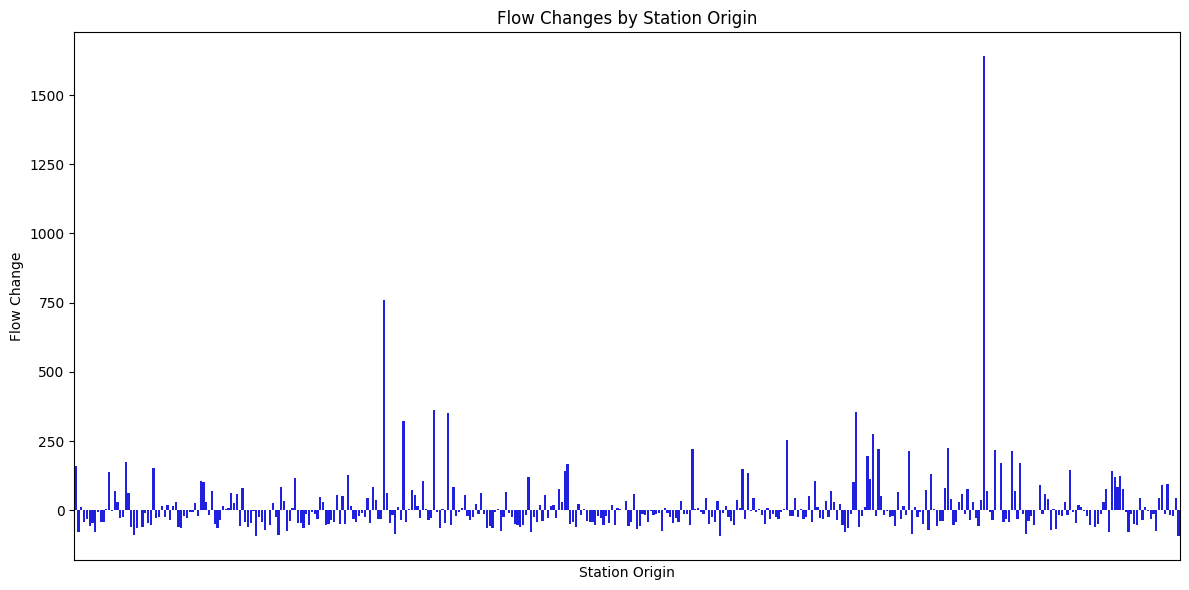

In [170]:
plt.figure(figsize=(12, 6))
sns.barplot(data=result, x='station_destination', y='flows_change2', color='b')
plt.xlabel('Station Origin')
plt.ylabel('Flow Change')
plt.title('Flow Changes by Station Origin')
plt.xticks([])
plt.tight_layout()
plt.show()


In [76]:
flows["predicted_flows"] = round(flows["flows"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
predicted_flows = flows.pivot_table(values ="flows", index="station_destination", columns = "station_origin",
                            aggfunc=np.sum, margins=True)
predicted_flows

/var/folders/60/b7504ly50v1_fz0lr9fy5tt00000gn/T/ipykernel_3488/278079885.py:3: FutureWarning: The provided callable <function sum at 0x1046df700> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  predicted_flows = flows.pivot_table(values ="flows", index="station_destination", columns = "station_origin",
/var/folders/60/b7504ly50v1_fz0lr9fy5tt00000gn/T/ipykernel_3488/278079885.py:3: FutureWarning: The provided callable <function sum at 0x1046df700> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  predicted_flows = flows.pivot_table(values ="flows", index="station_destination", columns = "station_origin",
/var/folders/60/b7504ly50v1_fz0lr9fy5tt00000gn/T/ipykernel_3488/278079885.py:3: FutureWarning: The provided callable <function sum at 0x

station_origin,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_destination,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,345
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,750
Acton Town,NaN,NaN,NaN,0.0,2.0,NaN,95.0,2.0,NaN,4.0,...,43.0,0.0,20.0,1.0,NaN,2.0,NaN,1.0,NaN,2202
Aldgate,NaN,NaN,3.0,NaN,0.0,NaN,NaN,41.0,NaN,29.0,...,0.0,NaN,62.0,4.0,NaN,5.0,NaN,26.0,NaN,7782
Aldgate East,NaN,NaN,17.0,0.0,NaN,NaN,3.0,0.0,NaN,11.0,...,45.0,10.0,20.0,8.0,NaN,47.0,NaN,11.0,NaN,7932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,706
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242
Woodside Park,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,NaN,16.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,745


In [77]:
flows["predicted_flows"] = round(flows["predicted_flows"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
predicted_flows1 = flows.pivot_table(values ="predicted_flows", index="station_destination", columns = "station_origin",
                            aggfunc=np.sum, margins=True)
predicted_flows1

/var/folders/60/b7504ly50v1_fz0lr9fy5tt00000gn/T/ipykernel_3488/856430525.py:3: FutureWarning: The provided callable <function sum at 0x1046df700> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  predicted_flows1 = flows.pivot_table(values ="predicted_flows", index="station_destination", columns = "station_origin",
/var/folders/60/b7504ly50v1_fz0lr9fy5tt00000gn/T/ipykernel_3488/856430525.py:3: FutureWarning: The provided callable <function sum at 0x1046df700> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  predicted_flows1 = flows.pivot_table(values ="predicted_flows", index="station_destination", columns = "station_origin",
/var/folders/60/b7504ly50v1_fz0lr9fy5tt00000gn/T/ipykernel_3488/856430525.py:3: FutureWarning: The provided callab

station_origin,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_destination,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,345
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,750
Acton Town,NaN,NaN,NaN,0.0,2.0,NaN,95.0,2.0,NaN,4.0,...,43.0,0.0,20.0,1.0,NaN,2.0,NaN,1.0,NaN,2202
Aldgate,NaN,NaN,3.0,NaN,0.0,NaN,NaN,41.0,NaN,29.0,...,0.0,NaN,62.0,4.0,NaN,5.0,NaN,26.0,NaN,7782
Aldgate East,NaN,NaN,17.0,0.0,NaN,NaN,3.0,0.0,NaN,11.0,...,45.0,10.0,20.0,8.0,NaN,47.0,NaN,11.0,NaN,7932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,706
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242
Woodside Park,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,NaN,16.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,745


In [80]:
flows["predicted_flows2"] = round(flows["predicted_flows2"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
predicted_flows2 = flows.pivot_table(values ="predicted_flows2", index="station_destination", columns = "station_origin",
                            aggfunc=np.sum, margins=True)
predicted_flows2

/var/folders/60/b7504ly50v1_fz0lr9fy5tt00000gn/T/ipykernel_3488/1443774801.py:3: FutureWarning: The provided callable <function sum at 0x1046df700> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  predicted_flows2 = flows.pivot_table(values ="predicted_flows2", index="station_destination", columns = "station_origin",
/var/folders/60/b7504ly50v1_fz0lr9fy5tt00000gn/T/ipykernel_3488/1443774801.py:3: FutureWarning: The provided callable <function sum at 0x1046df700> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  predicted_flows2 = flows.pivot_table(values ="predicted_flows2", index="station_destination", columns = "station_origin",
/var/folders/60/b7504ly50v1_fz0lr9fy5tt00000gn/T/ipykernel_3488/1443774801.py:3: FutureWarning: The provided c

station_origin,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_destination,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,214
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,414
Acton Town,NaN,NaN,NaN,5.0,5.0,NaN,5.0,3.0,NaN,7.0,...,16.0,4.0,13.0,3.0,NaN,9.0,NaN,6.0,NaN,2402
Aldgate,NaN,NaN,22.0,NaN,25.0,NaN,NaN,8.0,NaN,28.0,...,43.0,NaN,41.0,7.0,NaN,31.0,NaN,20.0,NaN,7728
Aldgate East,NaN,NaN,22.0,23.0,NaN,NaN,11.0,8.0,NaN,28.0,...,44.0,11.0,41.0,7.0,NaN,33.0,NaN,20.0,NaN,8261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,2.0,2.0,NaN,NaN,NaN,NaN,2.0,...,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,769
Woodgrange Park,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95
Woodside Park,NaN,NaN,3.0,2.0,2.0,NaN,NaN,NaN,NaN,3.0,...,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,768


In [153]:
error = result['predicted_flows'] - result['flows']
error_std = np.std(error)

error2 = flows['predicted_flows2'] - flows['flows']
error_std2 = np.std(error2)

print("Standard deviation of prediction error:", error_std)
print("Standard deviation of prediction error:", error_std2)


Standard deviation of prediction error: 1473.006469048384
Standard deviation of prediction error: 230.07684870299218


In [28]:
flows['flow_change'] = flows['predicted_flows'] - flows['flows']
print("Flow changes for each station_origin:")
print(flows['flow_change'].head(10))


Flow changes for each station_origin:
0    70
1     0
2     0
3    77
4    12
5     2
6     3
7     1
8    -5
9     1
Name: flow_change, dtype: int64


##### 2 Times Flow change

In [168]:
# calculate the flow change
flows['flow_change'] = (flows['predicted_flows'] - flows['flows'])
# Get the top 10 largest in flow_change
largest_flow_changes = flows.nlargest(10, 'flow_change')

# Print result
print("Top 10 flow changes for each station_origin:")
print(largest_flow_changes[['station_origin', 'station_destination', 'flow_change']])


Top 10 flow changes for each station_origin:
          station_origin    station_destination  flow_change
32584      London Bridge      Bank and Monument        10522
32441   Liverpool Street               Moorgate         9267
32282   Liverpool Street      Bank and Monument         7299
56086           Waterloo              Southwark         7159
56133           Waterloo            Westminster         5839
8898        Canary Wharf            Heron Quays         5775
55951           Waterloo             Embankment         4985
54810           Victoria       St. James's Park         4906
2712   Bank and Monument       Liverpool Street         4773
50146          Stratford  Stratford High Street         4712


In [ ]:
# Calculate the number greater than 0, less than 0, and equal to 0 in flow_change
num_positive = (flows['flow_change'] > 0).sum()  # The number is greater than 0
num_negative = (flows['flow_change'] < 0).sum()  # The number less than 0
num_zero = (flows['flow_change'] == 0).sum()  # The number of zeros

# Calculate the total
total_count = len(flows['flow_change'])

# Calculate their respective proportions
percent_positive = (num_positive / total_count) * 100  # The number is greater than 0
percent_negative = (num_negative / total_count) * 100  # The number less than 0
percent_zero = (num_zero / total_count) * 100  # The number of zeros

# print result
print("Flow changes summary:")
print("Number of positive flow changes:", num_positive, ", Percentage:", percent_positive)
print("Number of negative flow changes:", num_negative, ", Percentage:", percent_negative)
print("Number of zero flow changes:", num_zero, ", Percentage:", percent_zero)

In [31]:
flows['origin_to_destination'] = flows['station_origin'] + ' to ' + flows['station_destination']
print(flows[['origin_to_destination','flow_change']].head())

             origin_to_destination  flow_change
0  Abbey Road to Bank and Monument           70
1            Abbey Road to Beckton            0
2          Abbey Road to Blackwall            0
3       Abbey Road to Canary Wharf           77
4       Abbey Road to Canning Town           12


In [32]:
sorted_flows = flows[['origin_to_destination', 'flow_change']].sort_values(by='flow_change', ascending=False)
print(sorted_flows.head(10))


                       origin_to_destination  flow_change
32584     London Bridge to Bank and Monument         3143
32282  Liverpool Street to Bank and Monument         2633
32441           Liverpool Street to Moorgate         2056
56086                  Waterloo to Southwark         1774
56116                   Waterloo to Victoria         1719
32709      London Bridge to Liverpool Street         1689
56133                Waterloo to Westminster         1431
61381       Woolwich Arsenal to Canary Wharf         1371
2712   Bank and Monument to Liverpool Street         1349
8488       Canada Water to Bank and Monument         1300


In [140]:
sorted_flows = flows[['origin_to_destination', 'flow_change']].sort_values(by='flow_change', ascending=True)
print(sorted_flows.head(10))

                   origin_to_destination  flow_change
55890      Waterloo to Bank and Monument       -12011
55915           Waterloo to Canary Wharf        -7621
32609      London Bridge to Canary Wharf        -5839
50041      Stratford to Liverpool Street        -4562
54769          Victoria to Oxford Circus        -2881
32359     Liverpool Street to Farringdon        -2769
8792   Canary Wharf to Bank and Monument        -2190
2596   Bank and Monument to Canary Wharf        -2120
54841          Victoria to Warren Street        -2112
8636       Canada Water to London Bridge        -1840


##### 3 Times Flow change

In [141]:
# Calculate flow changes
flows['flow_change2'] = flows['predicted_flows2'] - flows['flows']

# Get the top 10 largest in flow_change
largest_flow_changes = flows.nlargest(10, 'flow_change2')

# print result
print("Top 10 flow changes for each station_origin:")
print(largest_flow_changes[['station_origin', 'station_destination', 'flow_change2']])

Top 10 flow changes for each station_origin:
         station_origin    station_destination  flow_change2
32584     London Bridge      Bank and Monument         19684
32441  Liverpool Street               Moorgate         15225
50146         Stratford  Stratford High Street         13440
56086          Waterloo              Southwark         13235
8898       Canary Wharf            Heron Quays         11159
56133          Waterloo            Westminster         10134
54810          Victoria       St. James's Park          9918
32282  Liverpool Street      Bank and Monument          9747
39181        Paddington           Edgware Road          8500
55951          Waterloo             Embankment          8210


In [142]:
num_positive = (flows['flow_change2'] > 0).sum()  
num_negative = (flows['flow_change2'] < 0).sum()
num_zero = (flows['flow_change2'] == 0).sum()

total_count = len(flows['flow_change2'])

percent_positive = (num_positive / total_count) * 100
percent_negative = (num_negative / total_count) * 100
percent_zero = (num_zero / total_count) * 100

print("Flow changes summary:")
print("Number of positive flow changes:", num_positive, ", Percentage:", percent_positive)
print("Number of negative flow changes:", num_negative, ", Percentage:", percent_negative)
print("Number of zero flow changes:", num_zero, ", Percentage:", percent_zero)


Flow changes summary:
Number of positive flow changes: 10258 , Percentage: 16.703303860746097
Number of negative flow changes: 34600 , Percentage: 56.339862895478156
Number of zero flow changes: 16555 , Percentage: 26.956833243775748


In [143]:
flows['origin_to_destination'] = flows['station_origin'] + ' to ' + flows['station_destination']
print(flows[['origin_to_destination','flow_change2']].head())

             origin_to_destination  flow_change2
0  Abbey Road to Bank and Monument             3
1            Abbey Road to Beckton            -1
2          Abbey Road to Blackwall            -3
3       Abbey Road to Canary Wharf             7
4       Abbey Road to Canning Town           -23


In [144]:
sorted_flows2 = flows[['origin_to_destination', 'flow_change2']].sort_values(by='flow_change2', ascending=False)
print(sorted_flows2.head(10))

                       origin_to_destination  flow_change2
32584     London Bridge to Bank and Monument         19684
32441           Liverpool Street to Moorgate         15225
50146     Stratford to Stratford High Street         13440
56086                  Waterloo to Southwark         13235
8898             Canary Wharf to Heron Quays         11159
56133                Waterloo to Westminster         10134
54810           Victoria to St. James's Park          9918
32282  Liverpool Street to Bank and Monument          9747
39181             Paddington to Edgware Road          8500
55951                 Waterloo to Embankment          8210


In [145]:
sorted_flows2 = flows[['origin_to_destination', 'flow_change2']].sort_values(by='flow_change2', ascending=True)
print(sorted_flows2.head(10))

                      origin_to_destination  flow_change2
55890         Waterloo to Bank and Monument        -11853
55915              Waterloo to Canary Wharf         -7913
32609         London Bridge to Canary Wharf         -6058
50041         Stratford to Liverpool Street         -4263
32359        Liverpool Street to Farringdon         -3238
54769             Victoria to Oxford Circus         -2562
8792      Canary Wharf to Bank and Monument         -2469
54841             Victoria to Warren Street         -2311
2596      Bank and Monument to Canary Wharf         -2275
29972  King's Cross St. Pancras to Victoria         -1946
